# Analysis of Scheduling Conflicts Data

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import os

congress = input("Congress (3-digit number): ")

# Specify directory for this congress
directory = str(congress)

# Create the directory if it doesn't exist
if not os.path.exists(directory):
    os.makedirs(directory)

# if int(congress) > 115:
#     results = pd.read_csv(str("C:\\Users\\rorey\\OneDrive - Bipartisan Policy Center\\Congress\\Modernization\\Scheduling Conflicts\\NEW\\Results\\"+str(congress)+"\\results"+str(congress)+".csv"))
#     hearing_data = pd.read_csv(str("C:\\Users\\rorey\\OneDrive - Bipartisan Policy Center\\Congress\\Modernization\\Scheduling Conflicts\\NEW\\Results\\"+str(congress)+"\\hearings"+str(congress)+".csv"))
#     members = pd.read_csv(str("C:\\Users\\rorey\\OneDrive - Bipartisan Policy Center\\Congress\\Modernization\\Scheduling Conflicts\\NEW\\Results\\"+str(congress)+"\\assignments"+str(congress)+".csv"),index_col=0)
    
# else:
#     results = pd.read_csv(str("C:\\Users\\rorey\\OneDrive - Bipartisan Policy Center\\Congress\\Modernization\\Scheduling Conflicts\\NEW\\Results\\2020 run\\results"+str(congress)+".csv"))
#     hearing_data = pd.read_csv(str("C:\\Users\\rorey\\OneDrive - Bipartisan Policy Center\\Congress\\Modernization\\Scheduling Conflicts\\NEW\\Results\\2020 run\\hearings"+str(congress)+".csv"))
#     members = pd.read_csv(str("C:\\Users\\rorey\\OneDrive - Bipartisan Policy Center\\Congress\\Modernization\\Scheduling Conflicts\\NEW\\Results\\2020 run\\assignments"+str(congress)+".csv"),index_col=0)    

results = pd.read_csv(directory + "/results.csv")
hearing_data = pd.read_csv(directory + "/hearings.csv")
members = pd.read_csv(directory + "/assignments.csv", index_col=0)


## Quick pulling together of number of assigments per member

In [5]:
members
members["id"] = members.index
members_long = pd.melt(members,id_vars=["id"])

In [6]:
# members_long.drop(["variable"],axis=1,inplace=True)
# members_long.dropna(inplace=True)

assign_dist = members_long.groupby(["value"]).count()
# assign_dist["member"] = assign_dist.index
assign_dist

assign_dist.to_csv(directory + "/assignmentsbymember.csv", index=True)

# Frequency of Conflicts by Committee

In [7]:
#committees with most conflicts, subcommittees broken out
hearings_combined = pd.concat([results["Hearing 1 Code"], results["Hearing 2 Code"]])

#import file with committee names
replacement = pd.read_csv(str("https://raw.githubusercontent.com/rachelorey/Scheduling-Conflicts-in-Congress/master/replacement"+str(congress)+".csv"))
#drop duplicates in the "Code" column of replacement
replacement.drop_duplicates(subset="Code",inplace=True)

#committes with most conflicts, sub > general
comm_freq  = pd.DataFrame(pd.DataFrame([i[0:2] for i in hearings_combined]).value_counts())
comm_freq.reset_index(inplace=True)
comm_freq.columns = ["Short Code","Scheduling Conflicts"]


comm_freq["Code"] = [i+"00" for i in comm_freq["Short Code"]]
comm_freq = comm_freq.merge(replacement, on='Code', how='left')
comm_freq.drop("Short Code",axis=1,inplace=True)
comm_freq.sort_values(by="Scheduling Conflicts",ascending=False,inplace=True)


# drop duplicates from members in place
members.drop_duplicates(inplace=True)

membercount = list()
for code in comm_freq["Code"]:
    membercount = membercount + [members.transpose()[code].count()]
    
comm_freq["Committee Members (Count)"] = membercount

display(comm_freq)

comm_freq.to_csv(directory + "/comm_freq.csv", index=False)

,Scheduling Conflicts,Code,Committee,Committee Members (Count)
0,1841,II00,Natural Resources,46
1,1607,IF00,Energy and Commerce,53
2,1523,GO00,Oversight and Accountability,48
3,1512,PW00,Transportation and Infrastructure,64
4,1414,AS00,Armed Services,59
5,1400,AP00,Appropriations,62
6,1242,ED00,Education and the Workforce,45
7,1205,FA00,Foreign Affairs,51
8,959,JU00,Judiciary,44
9,944,SY00,"Science, Space, and Technology",40


# Conflicts per Hearing

In [8]:
#reformatting dates
from datetime import datetime
import pandas as pd 

#results df
try:
    results["Date"] = [datetime.strptime(string, '%A, %B %d, %Y') for string in results["Date"]]
except:
    pass
results ["Month"] = [d.month for d in results["Date"]]
results ["Year"] = [d.year for d in results["Date"]]
results["Quarter"] = [(m-1)//3 + 1 for m in results["Month"]]

#hearings df
try:
    hearing_data["Date"] = [datetime.strptime(string, '%A, %B %d, %Y') for string in hearing_data["Date"]]
except:
    pass
hearing_data ["Month"] = [d.month for d in hearing_data["Date"]]
hearing_data ["Year"] = [d.year for d in hearing_data["Date"]]
hearing_data["Quarter"] = [(m-1)//3 + 1 for m in hearing_data["Month"]]

#setting up dataframes
conflictsxhearings_quarter = pd.DataFrame(columns=["year","quarter","conflicts","hearings"])
conflictsxhearings_month = pd.DataFrame(columns=["year","month","conflicts","hearings"])


unique_years = hearing_data["Year"].unique()

#for each year in the congress
for year in unique_years:

    for q in range(1,5):
        try:
            conflicts = results[results["Year"]==year]["Quarter"].value_counts()[q]
            hearings = hearing_data[hearing_data["Year"]==year]["Quarter"].value_counts()[q]
            res = pd.DataFrame([[year,q,conflicts,hearings]],columns = ["year","quarter","conflicts","hearings"])
            conflictsxhearings_quarter = pd.concat([conflictsxhearings_quarter, res])
        except:
            continue

    for m in range(1,13):
        try:
            conflicts = results[results["Year"]==year]["Month"].value_counts()[m]
        except:
            conflicts = 0
        try:
            hearings = hearing_data[hearing_data["Year"]==year]["Month"].value_counts()[m]
        except:
            hearings = 0
        res = pd.DataFrame([[year,m,conflicts,hearings]],columns = ["year","month","conflicts","hearings"])
        conflictsxhearings_month = pd.concat([conflictsxhearings_month, res])

print("\nConflicts per hearing per quarter")
display(conflictsxhearings_quarter)
print("\nConflicts per hearing per month")
display(conflictsxhearings_month)

conflictsxhearings_quarter.to_csv(directory + "/conflicts_by_hearing_quarter.csv")
conflictsxhearings_month.to_csv(directory + "/conflicts_by_hearing_month.csv")



Conflicts per hearing per quarter


,year,quarter,conflicts,hearings
0,2023,1,2147,298
0,2023,2,2176,395
0,2023,3,1114,251
0,2023,4,765,211
0,2024,1,1464,269
0,2024,2,1653,337



Conflicts per hearing per month


,year,month,conflicts,hearings
0,2023,1,6,8
0,2023,2,760,83
0,2023,3,1381,207
0,2023,4,735,123
0,2023,5,635,135
0,2023,6,806,137
0,2023,7,508,129
0,2023,8,2,5
0,2023,9,604,117
0,2023,10,133,46


In [9]:
# summarize conflicts by year
conflicts_by_year = pd.DataFrame(results["Year"].value_counts())
#save to directory
conflicts_by_year.to_csv(directory + "/conflicts_by_year.csv")

# Conflicts per Individual Member, Hearing

## Members sorted by those with most conflicts

In [10]:
results["MC"].value_counts()

MC
 Michael Waltz          117
 Richard McCormick       88
 Debbie Dingell          88
 Lisa C. McClain         84
 Daniel Webster          82
                       ... 
 Alexander X. Mooney      1
 Rosa L. DeLauro          1
 Steny H. Hoyer           1
 Mark Pocan               1
John Garamendi            1
Name: count, Length: 388, dtype: int64

## Hearings with most conflicts

XXX not sure what's going on here

In [11]:
# conflicts_hearing = pd.concat([results["Hearing 1 Link"], results["Hearing 2 Link"]])
# conflicts_hearing = pd.DataFrame(conflicts_hearing.value_counts(),columns=["Scheduling Conflicts"])
# conflicts_hearing["Committee"] = [hearing_data[hearing_data["Link"]==link]["Committee"].values[0] for link in conflicts_hearing.index]
# conflicts_hearing["Code"] = [hearing_data[hearing_data["Link"]==link]["Code"].values[0] for link in conflicts_hearing.index]
# conflicts_hearing.index.rename("Link",inplace=True)

# maxhearing = str(conflicts_hearing.reset_index().iloc[0,0])
# maxcommittee = conflicts_hearing["Committee"].values[0]
# maxcommittee_code = conflicts_hearing["Code"].values[0]
# maxhearing_conflicts = results[(results["Hearing 1 Link"]==maxhearing)|(results["Hearing 2 Link"]==maxhearing)]
# memberswconflict = len(maxhearing_conflicts.drop_duplicates(subset="MC"))
# membersincomm = len(members.loc[str(maxcommittee_code)].dropna())


# print("The",maxcommittee,"had the hearing with the single highest number of scheduling conflicts.\n\nLink to hearing:",maxhearing,end="\n\n")
# print(memberswconflict,"members at the hearing had a conflict, out of",membersincomm,"total members.",end="\n\n")
# print("That's",round(memberswconflict/membersincomm,2),"percent of membership with a conflict")

# conflicts_hearing.plot.hist(title="Distribution of Conflicts per Committee Hearing",ylabel="test")
# conflicts_hearing.to_csv(directory + "/conflictsperhearing.csv", index=True)

In [12]:
# print(round(len(conflicts_hearing)/len(hearing_data),2),"percent of hearings had at least one conflict")

In [13]:
# ## GET AVERAGE NUMBER OF MEMBERS WITH CONFLICTS PER HEARING

# membership = [len(members.loc[str(com)].dropna()) for com in members.index]
# membership = pd.DataFrame(membership,index=members.index)

# conflicts_hearing.reset_index(inplace=True)
# averageconflicts = conflicts_hearing
# averageconflicts.index = conflicts_hearing["Code"]
# averageconflicts.drop(["Code"],axis=1,inplace=True)
# averageconflicts = averageconflicts.join(membership,how='left')

# averageconflicts = averageconflicts.rename(columns={0:"NumMembers"})

# averageconflicts["Percent_Conflict"] = averageconflicts["Scheduling Conflicts"]/averageconflicts["NumMembers"]

# print("Average Members in Each Hearing with a Conflict [excluding hearings with no conflicts]")
# averageconflicts["Percent_Conflict"].mean()

In [14]:
# ## MERGING WITH HEARING DATA TO GET PERCENT INCLUDING HEARINGS WITHOUT CONFLICTS

# averageconflicts.reset_index(inplace=True)
# averageconflicts.set_index("Link",inplace=True)
# averageconflicts.drop(["Committee"],inplace=True,axis=1)

# hearing_data.set_index("Link",inplace=True)

# averageconflicts1 = hearing_data.join(averageconflicts,how="left")

# averageconflicts1["Scheduling Conflicts"].fillna(0,inplace=True)
# averageconflicts1["Percent_Conflict"].fillna(0,inplace=True)

# print("Including hearings with no conflicts, average percent of members with a conflict overall")
# print(averageconflicts1["Percent_Conflict"].mean())

# Conflicts by Committee Assignments

/tmp/ipykernel_2783/2610154926.py:5: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  member_count = pd.DataFrame(pd.value_counts(member_count["value"]))
/tmp/ipykernel_2783/2610154926.py:8: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  conflict_count = pd.DataFrame(pd.value_counts(results["MC"]))


<Axes: title={'center': 'Relationship between Committee Assignments and Scheduling Conflicts\n(including subcommittee assignments)'}, xlabel='No. Committees', ylabel='No. Conflicts'>

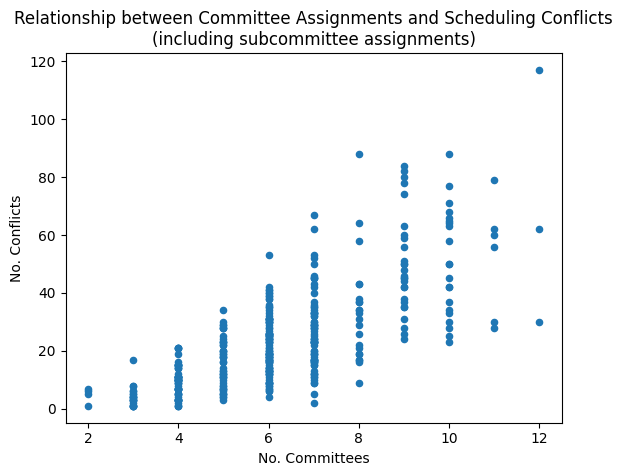

In [15]:
import pandas as pd

member_count = pd.melt(members).drop(["variable"],axis=1)
member_count = member_count[~member_count["value"].isna()]
member_count = pd.DataFrame(pd.value_counts(member_count["value"]))
member_count.columns = ["No. Committees"]

conflict_count = pd.DataFrame(pd.value_counts(results["MC"]))
conflict_by_assignments = pd.merge(member_count,conflict_count,left_index = True,right_index=True)
conflict_by_assignments.columns = ["No. Committees","No. Conflicts"]

conflict_by_assignments.to_csv(directory + "/conflict_by_assignment.csv")
conflict_by_assignments.plot.scatter(x="No. Committees", y="No. Conflicts", title="Relationship between Committee Assignments and Scheduling Conflicts\n(including subcommittee assignments)")

In [16]:
member_count["No. Committees"].mean()

4.709734513274336

In [17]:
# hearing_data[hearing_data["Hearing Title"].str.contains("Mark up",case=False)|hearing_data["Hearing Title"].str.contains("Markup",case=False)]

# Overlap

In [18]:
members.reset_index(inplace=True)
members.drop(["id"],axis=1,inplace=True)
members_long = members[members['index'].str.contains('00')]
members_long = pd.melt(members_long,id_vars=["index"])
members_long.drop(["variable"],axis=1,inplace=True)
members_long.dropna(inplace=True)

In [19]:
hearing_data["ShortCode"] = hearing_data["Code"].str[:-2]
hearing_freq = hearing_data.groupby(["ShortCode"]).count()[["Date"]]
hearing_freq.to_csv(directory + "/hearingfreq.csv", index=True)

In [22]:
comms = members_long["index"].unique()
overlap = pd.DataFrame(columns=comms,index=comms)

for comm in range(len(comms)):
    l1 = list(members_long[members_long['index']==comms[comm]]["value"])
    for comm2 in range(len(comms)):
        l2 = list(members_long[members_long['index']==comms[comm2]]["value"])
#         print(comm,comm2)
        numoverlap = len([value for value in l1 if value in l2])
        overlap.iloc[comm,comm2] = numoverlap

In [23]:
overlap

,AG00,AP00,AS00,BU00,ED00,IF00,SO00,BA00,FA00,HM00,...,GO00,VC00,RU00,SY00,SM00,PW00,VR00,WM00,IG00,ZS00
AG00,54,2,12,0,5,3,0,5,4,0,...,4,2,3,7,5,12,3,1,4,2
AP00,2,61,0,7,1,0,3,0,0,2,...,2,1,1,5,1,0,2,0,1,3
AS00,12,0,58,3,6,1,1,1,8,4,...,6,3,1,4,3,6,5,2,6,7
BU00,0,7,3,35,7,4,1,1,0,2,...,2,0,4,0,0,1,1,10,0,0
ED00,5,1,6,7,44,2,2,1,4,0,...,5,0,2,4,1,8,2,3,1,3
IF00,3,0,1,4,2,52,0,0,1,2,...,1,5,1,3,0,0,1,0,1,2
SO00,0,3,1,1,2,0,10,1,1,3,...,0,1,1,1,0,1,0,1,0,0
BA00,5,0,1,1,1,0,1,52,9,1,...,6,0,2,3,4,0,0,0,3,3
FA00,4,0,8,0,4,1,1,9,50,2,...,5,3,0,5,2,7,3,1,5,2
HM00,0,2,4,2,0,2,3,1,2,33,...,4,2,0,1,3,4,3,0,0,1


In [24]:
overlap.to_csv(directory + "/overlap.csv",index=True)